### Imports

In [183]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from datetime import datetime

In [61]:
#A ne pas executer si déjà téléchargés
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

### Test avec fetch20newsgroup

In [62]:
'''from sklearn.datasets import fetch_20newsgroups
X_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)
X_train'''

"from sklearn.datasets import fetch_20newsgroups\nX_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)\nX_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)\nX_train"

In [63]:
#X_train[0]

### Test, traitement, récupération des traces

In [64]:
data_1 = pd.read_json('Data\messages_chat_seance1\exportChatMessage\\0dfd43cb-9957-4102-954a-899ca075e56d.json')
data_2 = pd.read_json('Data\messages_chat_seance1\exportChatMessage\\1db9dee2-2702-457f-aa07-6b60589446ce.json')
data_3 = pd.read_json('Data\messages_chat_seance1\exportChatMessage\\2ccf746f-62b9-4690-8bff-59c49fb2c310.json')

Recupérer ici la fin du fichier : seance 1 ne regroupe que 3 messages :: mettre dans seance 1 tous les messages de la seance 1
creer csv avec toutes les données : seance + nomfichier comme id.

In [65]:
# Gros df avec les 3 données
messages_df = pd.concat([data_1,data_2,data_3],axis = 0)
messages_df.reset_index(drop=True, inplace=True) #Créer un id ? Plus tard, quand mesure d'impact -> nécessité de tracer
messages_df.head(5)

,user,role,message,timestamp
0,194872,Driver,roro,2024-10-09 04:24:09.074000+00:00
1,194872,Driver,Qui est là,2024-10-09 04:27:03.939000+00:00
2,145797,Driver,Bonjour,2024-10-09 04:22:52.924000+00:00
3,200807,Navigator,Bonjour,2024-10-09 04:24:14.448000+00:00
4,145797,Driver,tu pense si je fais un for in in range avec un...,2024-10-09 04:25:31.692000+00:00


In [90]:
#understanding json files
data_1

,user,role,message,timestamp
0,194872,Driver,roro,2024-10-09 04:24:09.074000+00:00
1,194872,Driver,Qui est là,2024-10-09 04:27:03.939000+00:00


In [91]:
f = open('Data\messages_chat_seance1\exportChatMessage\\0dfd43cb-9957-4102-954a-899ca075e56d.json','r')
d = json.load(f)
d

[{'user': '194872',
  'role': 'Driver',
  'message': 'roro',
  'timestamp': '2024-10-09T04:24:09.074Z'},
 {'user': '194872',
  'role': 'Driver',
  'message': 'Qui est là',
  'timestamp': '2024-10-09T04:27:03.939Z'}]

In [206]:
##Fonction(s) pour traiter les messages

def parse_json_files_in_folder(folder_path):
    """
    Parses all JSON files in a folder and concatenates them into a pandas DataFrame.

    Args:
        folder_path (str): The path to the folder containing the JSON files.

    Returns:
        pandas.DataFrame: A DataFrame containing the concatenated data from all JSON files.
    """
    all_data = pd.DataFrame()
    groupid = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            filepath = os.path.join(folder_path, filename)
            data = pd.read_json(filepath)
            data['groupID'] = groupid
            data['fileID'] = filename[:-5]
            all_data = pd.concat([all_data,data],axis = 0)
            groupid += 1
    all_data.reset_index(inplace = True, drop = True)
    all_data.index.names = ["messageID"]
    # extracting date from timestamp
    all_data['date'] = [datetime.date(d) for d in all_data['timestamp']] 

    # extracting time from timestamp
    all_data['time'] = [datetime.time(d).replace(microsecond=0) for d in all_data['timestamp']]
    all_data.drop(['timestamp'],axis = 1,inplace = True)
    return all_data


In [207]:
seance1_df = parse_json_files_in_folder('Data\messages_chat_seance1\exportChatMessage')
print("seance1_df shape : ",seance1_df.shape)
seance1_df

seance1_df shape :  (440, 7)


,user,role,message,groupID,fileID,date,time
messageID,,,,,,,
0,186202.0,Navigator,"Tu es qui ,",0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:10
1,186202.0,Navigator,On se met 5 partout ok ?,0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:23
2,183897.0,Driver,Opé,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:22
3,183897.0,Driver,Opé lmkt,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:39
4,193392.0,Navigator,A PAR SA LE COUZ,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:46
...,...,...,...,...,...,...,...
435,188437.0,Navigator,tu as fais des tests?,49,f374e410-f777-4ef0-8a15-14267dd8ed09,2024-10-09,04:28:34
436,200552.0,Driver,pas encore,49,f374e410-f777-4ef0-8a15-14267dd8ed09,2024-10-09,04:28:42
437,188437.0,Navigator,ça l'air correct,49,f374e410-f777-4ef0-8a15-14267dd8ed09,2024-10-09,04:29:16


In [208]:
seance2_df = parse_json_files_in_folder('Data\messages_chat_seance2\exportChatMessage')
print("seance2_df shape : ",seance2_df.shape)
seance2_df

seance2_df shape :  (1315, 7)


,groupID,fileID,user,role,message,date,time
messageID,,,,,,,
0,1,00c09563-99f4-42da-9346-d73355a9b8d9,183337.0,Driver,bonjour,2024-11-12,04:30:24
1,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,bonjour,2024-11-12,04:30:44
2,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,tu es bloqué?,2024-11-12,04:36:03
3,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,hésite pas si t'as une idée,2024-11-12,04:39:50
4,1,00c09563-99f4-42da-9346-d73355a9b8d9,183337.0,Driver,ok,2024-11-12,04:40:06
...,...,...,...,...,...,...,...
1310,81,fbe22b37-299a-4851-a4a0-c2f152bc835f,144245.0,Navigator,c'est bon,2024-11-12,04:48:02
1311,81,fbe22b37-299a-4851-a4a0-c2f152bc835f,192807.0,Driver,"A la base, ce n'est pas total non ?",2024-11-12,04:48:09
1312,81,fbe22b37-299a-4851-a4a0-c2f152bc835f,192807.0,Driver,Tu voulais tous les mettre total non ?,2024-11-12,04:49:41


In [209]:
#Ajout d'une séance colonne pour différencier les séances
seance1_df['seanceID'] = 1
seance1_df.head(5)

,user,role,message,groupID,fileID,date,time,seanceID
messageID,,,,,,,,
0,186202.0,Navigator,"Tu es qui ,",0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:10,1
1,186202.0,Navigator,On se met 5 partout ok ?,0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:23,1
2,183897.0,Driver,Opé,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:22,1
3,183897.0,Driver,Opé lmkt,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:39,1
4,193392.0,Navigator,A PAR SA LE COUZ,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:46,1


In [210]:
seance2_df['seanceID'] = 2
seance2_df.head(5)

,groupID,fileID,user,role,message,date,time,seanceID
messageID,,,,,,,,
0,1,00c09563-99f4-42da-9346-d73355a9b8d9,183337.0,Driver,bonjour,2024-11-12,04:30:24,2
1,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,bonjour,2024-11-12,04:30:44,2
2,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,tu es bloqué?,2024-11-12,04:36:03,2
3,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,hésite pas si t'as une idée,2024-11-12,04:39:50,2
4,1,00c09563-99f4-42da-9346-d73355a9b8d9,183337.0,Driver,ok,2024-11-12,04:40:06,2


In [211]:
all_messages_df = pd.concat([seance1_df,seance2_df],axis = 0,ignore_index = True)
all_messages_df.index.names=['messageID']
#print(all_messages_df.head(5),all_messages_df.tail(5))
all_messages_df

,user,role,message,groupID,fileID,date,time,seanceID
messageID,,,,,,,,
0,186202.0,Navigator,"Tu es qui ,",0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:10,1
1,186202.0,Navigator,On se met 5 partout ok ?,0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:23,1
2,183897.0,Driver,Opé,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:22,1
3,183897.0,Driver,Opé lmkt,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:39,1
4,193392.0,Navigator,A PAR SA LE COUZ,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:46,1
...,...,...,...,...,...,...,...,...
1750,144245.0,Navigator,c'est bon,81,fbe22b37-299a-4851-a4a0-c2f152bc835f,2024-11-12,04:48:02,2
1751,192807.0,Driver,"A la base, ce n'est pas total non ?",81,fbe22b37-299a-4851-a4a0-c2f152bc835f,2024-11-12,04:48:09,2
1752,192807.0,Driver,Tu voulais tous les mettre total non ?,81,fbe22b37-299a-4851-a4a0-c2f152bc835f,2024-11-12,04:49:41,2


In [214]:
all_messages_df.to_csv('all_messages.csv',date_format='%Y%m%d') #vérifier ordre date + attention symbole de séparation ligne 1 virgule

### Truncated SVD -- LSA (Latent Semantic Analysis)

In [215]:
#Messages sous forme de tableau
seance1_msg = seance1_df['message'].values #Récupère les valeurs de la colonne message et en fait une liste
print(len(seance1_msg))
#print(seance1_msg)
seance2_msg = seance2_df['message'].values #Récupère les valeurs de la colonne message et en fait une liste
print(len(seance2_msg))
#print(seance2_msg)

440
1315


In [76]:
tokenizer = RegexpTokenizer(r'\b\w{3,}\b') #garde les mots d'au moins trois lettres, avec dans les mots soit des lettres, soit des chiffres (pas de caractères spéciaux)
stop_words = list(set(stopwords.words("french"))) #On enlève les mots communs sans interêt en français ; on garde ceux en anglais car indique probablement du code
print(stop_words)
stop_words += list(string.punctuation)

['ces', 'eusses', 'aurions', 'fussiez', 'dans', 'eues', 'on', 'eue', 'aurez', 'ton', 'eussiez', 'avait', 'serai', 'fûmes', 'ayante', 'aux', 'étaient', 'furent', 'avais', 'un', 'ou', 'eussent', 'fut', 'eurent', 'il', 'aurait', 'mes', 'qu', 'par', 'toi', 'me', 'fût', 'eux', 'avons', 'seriez', 'suis', 'ma', 'aies', 'étant', 'au', 'ce', 'du', 'eut', 'se', 'des', 'eu', 'eûtes', 'en', 'ils', 'aurons', 'votre', 'vous', 'seras', 'sur', 'étions', 'auriez', 'que', 'aient', 'nous', 'aviez', 'je', 'c', 'aura', 'le', 'ayez', 'es', 'serait', 'avions', 'l', 'as', 'étais', 'ta', 'notre', 'étée', 'serais', 'te', 'mais', 'serez', 'y', 'son', 'tes', 'à', 'était', 'serons', 'qui', 'soit', 'avec', 'étées', 'avaient', 's', 'eusse', 'fûtes', 't', 'aurais', 'êtes', 'fusse', 'soient', 'de', 'eus', 'étantes', 'fussions', 'avez', 'étante', 'ses', 'et', 'fus', 'auras', 'été', 'serions', 'soyons', 'ayants', 'eussions', 'ait', 'mon', 'la', 'fusses', 'nos', 'sa', 'fussent', 'auraient', 'moi', 'eûmes', 'est', 'ayant'

In [77]:
#tf-idf = Term Frequency Inverse Document Frequency of records
#tf = term frequency
#idf = inverse codument frequency (les mots les plus communs dans les documents semblent moins significatifs)
tfidf = TfidfVectorizer(lowercase=True, #Convertir tous les caractères en lowercase avant de tokenize
                        stop_words=stop_words,
                        tokenizer=tokenizer.tokenize,
                        max_df=0.7, #ignore les items ayant une fréquence supérieure à x
                        min_df=0.015 #ignore les items ayant une fréquence inférieure à x
                       )

tfidf_train_sparse = tfidf.fit_transform(seance1_msg) # equivalent à fit puis transform : fit entraine le modèle, transform applique le modele sur le dataset
#Crée un DF avec les résultats
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), #transforme une matrice en tableau 2D
                        columns=tfidf.get_feature_names_out()) #get output feature names for transfomation = les mots // les noms des colonnes ?

print('Shape :',tfidf_train_df.shape)
tfidf_train_df.head(2)

Shape : (440, 20)


c:\Users\cbd65\anaconda3\envs\jupyterenv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,activité,bah,bon,comment,faire,fais,fait,faut,fini,main,non,ouais,oui,peux,quoi,sais,salut,tableau,veux,vois
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
#Transforme la matrice du dessus en une autre plus réduite en utilisant la décomposition en valeurs singulières A = U * Sigma * V_T.

#n_components = dimension de l'output (100 recommendé pour LSA, doit être <= au nombre de features)
lsa_obj = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(tfidf_train_df)
Sigma = lsa_obj.singular_values_ # Matrice centrale, valeurs correcspondant à chaque composant sélectionné
V_T = lsa_obj.components_.T # components_ = vecteurs singuliers de droite de l'input data
print("V_T shape : ",V_T.shape)

V_T shape :  (20, 20)


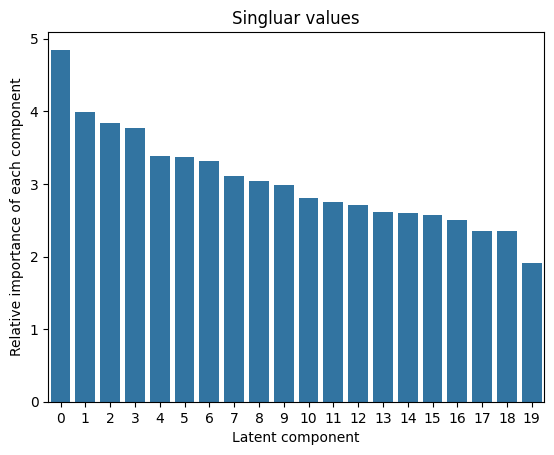

In [79]:
#Affichage de l'importance de chaque composante
axis_object = sns.barplot(x=list(range(len(Sigma))), y = Sigma)
plt.xlabel("Latent component")
plt.ylabel('Relative importance of each component')
plt.title("Singluar values")
plt.show(axis_object)

In [80]:
#Transformation de V_T en DF pour une utilisation plus facile
term_topic_matrix = pd.DataFrame(data=V_T,
                                 index = tfidf_train_df.columns,
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])
term_topic_matrix.head(3)

,Latent_concept_0,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10,Latent_concept_11,Latent_concept_12,Latent_concept_13,Latent_concept_14,Latent_concept_15,Latent_concept_16,Latent_concept_17,Latent_concept_18,Latent_concept_19
activité,0.000565,0.005773,-0.001997,0.004971,0.007559,0.001825,0.034355,-0.018979,-0.026452,0.157994,0.072556,0.456579,0.253099,-0.108628,-0.009893,0.110679,0.003384,-0.008375,0.021835,0.818645
bah,0.044633,-0.002315,0.002000,-0.007283,0.006878,0.068611,0.082061,-0.023649,-0.019650,-0.007937,-0.000312,-0.030747,-0.002718,0.004739,0.007485,-0.013426,0.002054,-0.171344,0.977119,-0.010550
bon,0.993513,-0.079948,0.017527,-0.025439,0.017438,-0.028047,0.005579,0.019879,-0.010384,-0.023795,-0.029910,0.010543,0.013555,0.010638,0.001181,-0.006782,0.010668,0.001289,-0.043924,0.000524


In [263]:
def visualize_top_bottom_terms_component(matrix,nbComponent):
    name_col = 'Latent_concept_'+str(nbComponent)
    data = matrix[name_col]
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    data = data.sort_values(ascending=True)
    bottom_10 = data[:10]
    #fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(5,5))

    plt.subplot(1,2,1)
    plt.bar(top_10.index,top_10.values)
    plt.xticks(top_10.index, top_10.index, rotation='vertical')
    plt.title("Top 10")

    plt.subplot(1,2,2)
    plt.bar(bottom_10.index,bottom_10.values)
    plt.xticks(bottom_10.index, bottom_10.index, rotation=45,ha='center')
    plt.title("Bottom 10")

    plt.tight_layout()

    plt.show()


In [274]:
def visualize_top_bottom_terms_component(matrix,nbComponent):
    name_col = 'Latent_concept_'+str(nbComponent)
    data = matrix[name_col]
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    data = data.sort_values(ascending=True)
    bottom_10 = data[:10]
    #fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(5,5))

    fig, (ax1,ax2) = plt.subplots(1,2)

    y_pos = np.arange(len(top_10.index))

    ax1.barh(y_pos, top_10.values, align='center')
    ax1.set_yticks(y_pos, labels=top_10.index)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_title('Top 10')

    #fig, ax = plt.subplots(1,2,2)

    y_pos = np.arange(len(bottom_10.index))

    ax2.barh(y_pos, bottom_10.values, align='center')
    ax2.set_yticks(y_pos, labels=bottom_10.index)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Bottom 10')

    plt.tight_layout()
    plt.show()


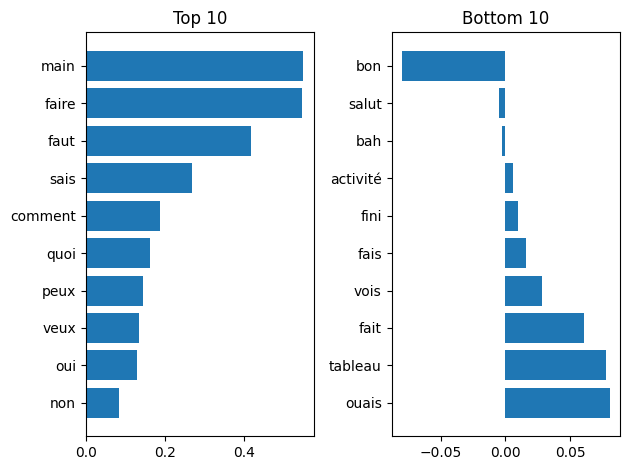

In [275]:
visualize_top_bottom_terms_component(term_topic_matrix,1)

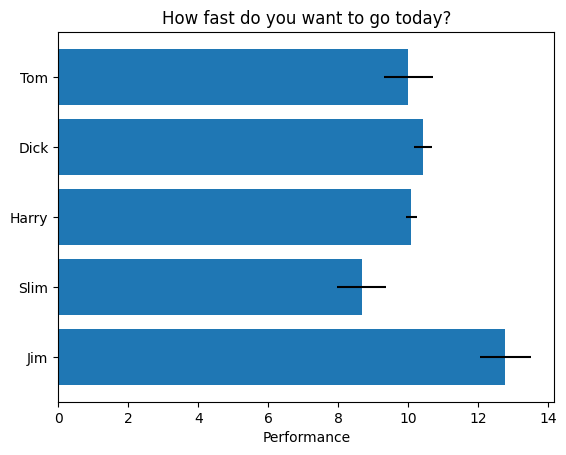

In [265]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

plt.show()

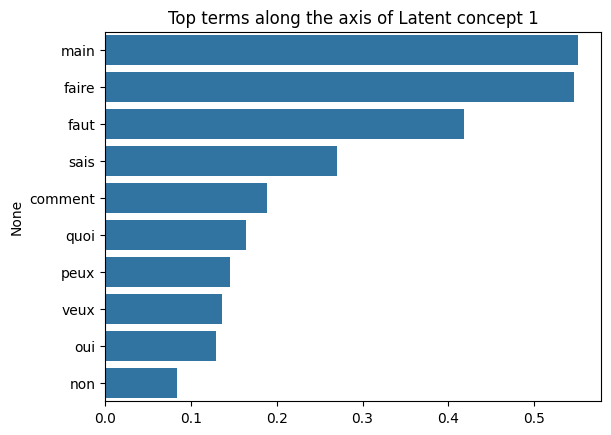

In [220]:
data = term_topic_matrix['Latent_concept_1']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 1')
fig = sns.barplot(x= top_10.values, y=top_10.index)

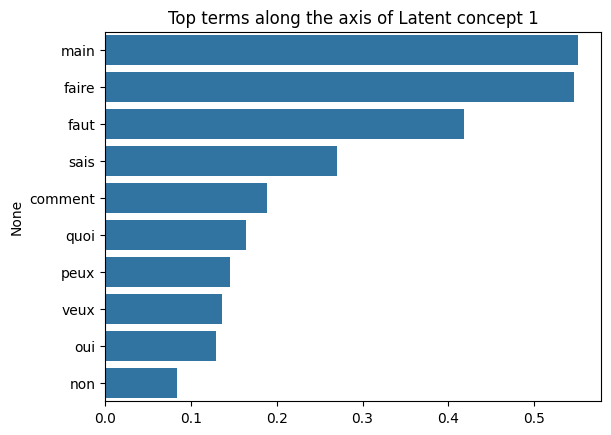

In [221]:
data = term_topic_matrix[f'Latent_concept_1']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 1')
fig = sns.barplot(x= top_10.values, y=top_10.index)

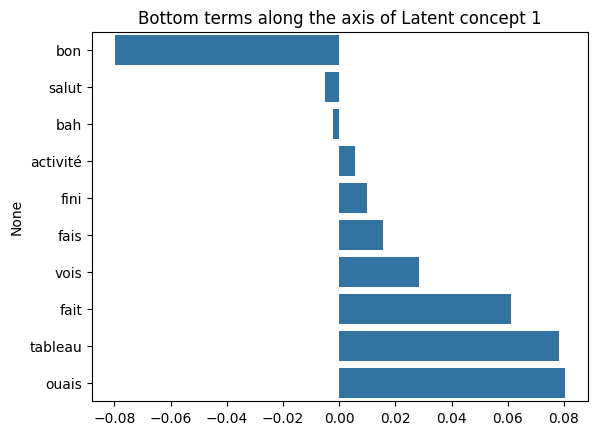

In [222]:
data = term_topic_matrix[f'Latent_concept_1']
data = data.sort_values(ascending=True)
top_10 = data[:10]
plt.title('Bottom terms along the axis of Latent concept 1')
fig = sns.barplot(x= top_10.values, y=top_10.index)

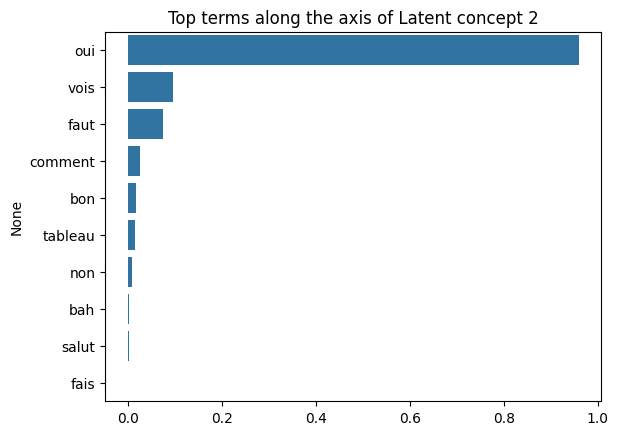

In [86]:
data = term_topic_matrix[f'Latent_concept_2']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 2')
fig = sns.barplot(x= top_10.values, y=top_10.index)

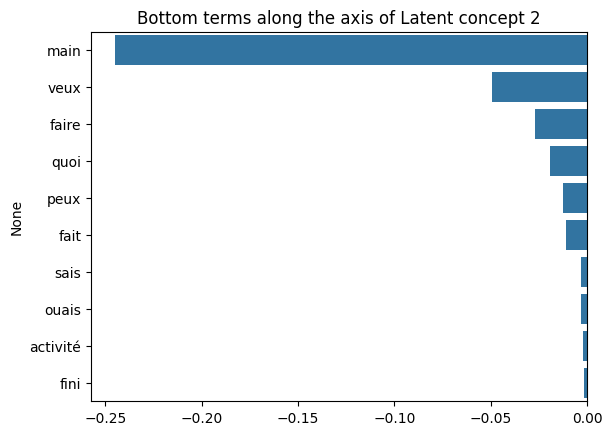

In [87]:
data = term_topic_matrix[f'Latent_concept_2']
data = data.sort_values(ascending=True)
top_10 = data[:10]
plt.title('Bottom terms along the axis of Latent concept 2')
fig = sns.barplot(x= top_10.values, y=top_10.index)

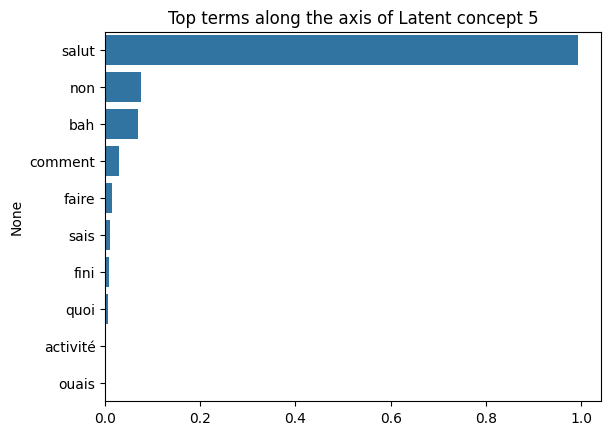

In [88]:
data = term_topic_matrix[f'Latent_concept_5']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 5')
fig = sns.barplot(x= top_10.values, y=top_10.index)

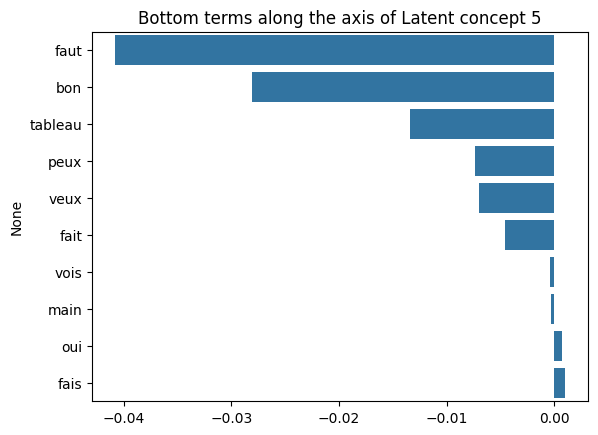

In [89]:
data = term_topic_matrix[f'Latent_concept_5']
data = data.sort_values(ascending=True)
top_10 = data[:10]
plt.title('Bottom terms along the axis of Latent concept 5')
fig = sns.barplot(x= top_10.values, y=top_10.index)